# **Analytics Vidhya Practice Problem: Twitter Sentiment Analysis 2019**

Sentiment Analysis in Python with sklearn package

# https://satya-python.blogspot.com/

Jupyter Notebook in Google Colab


In [222]:
# Importing required packages

import numpy as np
import pandas as pd
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV

from google.colab import files

import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Reading Data

In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## EDA - Exploratory Data Analysis

In [224]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
id       31962 non-null int64
label    31962 non-null int64
tweet    31962 non-null object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [225]:
# Checking for NULL/missing values
train.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [0]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stopwords(string):
    word_list = [word.lower() for word in string.split()]
    stopwords_list = list(stopwords.words("english"))
    for word in word_list:
        if word in stopwords_list:
            word_list.remove(word)
    return ' '.join(word_list)


In [227]:
train.head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [228]:
train['tweet_length'] = train['tweet'].apply(len)
train['tweet'] = train['tweet'].map(lambda x: re.sub('\\n',' ',str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'\W',' ',str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'https\s+|www.\s+',r'', str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'http\s+|www.\s+',r'', str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'\s+[a-zA-Z]\s+',' ',str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'\^[a-zA-Z]\s+',' ',str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'\s+',' ',str(x)))
train['tweet'] = train['tweet'].str.lower()

train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\’", "\'", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"won\'t", "will not", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"can\'t", "can not", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"don\'t", "do not", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"dont", "do not", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"n\’t", " not", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"n\'t", " not", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\'re", " are", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\'s", " is", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\’d", " would", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\d", " would", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\'ll", " will", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\'t", " not", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\'ve", " have", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\'m", " am", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\n", "", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\r", "", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"[0-9]", "digit", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\'", "", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\"", "", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'[?|!|\'|"|#]',r'', str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'[.|,|)|(|\|/]',r' ', str(x)))
train['tweet'] = train['tweet'].apply(lambda x: remove_stopwords(x))
train.head(10)

,id,label,tweet,tweet_length
0,1,0,user father dysfunctional is selfish drags kid...,102
1,2,0,user user thanks lyft credit use cause don off...,122
2,3,0,bihday majesty,21
3,4,0,model love take all time urð ð ð ð ð ð ð ð,86
4,5,0,factsguide society motivation,39
5,6,0,would would huge fan fare big talking they lea...,116
6,7,0,user camping tomorrow user user user user user...,74
7,8,0,next school year the year exams ð think that ð...,143
8,9,0,won love land allin cavs champions cleveland c...,87
9,10,0,user user welcome m so gr would,50


In [229]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
id       17197 non-null int64
tweet    17197 non-null object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


In [230]:
test.tail(10)

,id,tweet
17187,49150,loving lifeðºð¸âï¸ð #createyourfutu...
17188,49151,"black professor demonizes, proposes nazi style..."
17189,49152,learn how to think positive. #positive #ins...
17190,49153,"we love the pretty, happy and fresh you! #teen..."
17191,49154,2_damn_tuff-ruff_muff__techno_city-(ng005)-web...
17192,49155,thought factory: left-right polarisation! #tru...
17193,49156,feeling like a mermaid ð #hairflip #neverre...
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...
17195,49158,"happy, at work conference: right mindset leads..."
17196,49159,"my song ""so glad"" free download! #shoegaze ..."


In [231]:
test['tweet'] = test['tweet'].map(lambda x: re.sub('\\n',' ',str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r'\W',' ',str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r'\s+[a-zA-Z]\s+',' ',str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r'\^[a-zA-Z]\s+',' ',str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r'\s+',' ',str(x)))
test['tweet'] = test['tweet'].str.lower()

test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\’", "\'", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"won\'t", "will not", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"can\'t", "can not", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"don\'t", "do not", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"dont", "do not", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"n\’t", " not", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"n\'t", " not", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\'re", " are", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\'s", " is", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\’d", " would", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\d", " would", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\'ll", " will", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\'t", " not", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\'ve", " have", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\'m", " am", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\n", "", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\r", "", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"[0-9]", "digit", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\'", "", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\"", "", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r'[?|!|\'|"|#]',r'', str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r'[.|,|)|(|\|/]',r' ', str(x)))
test['tweet'] = test['tweet'].apply(lambda x: remove_stopwords(x))

test.tail(10)

,id,tweet
17187,49150,loving lifeð ºð â ï ð createyourfuture lifesty...
17188,49151,black professor demonizes proposes nazi style ...
17189,49152,learn to think positive positive instagram ins...
17190,49153,love pretty happy fresh teenilicious fixdermat...
17191,49154,would_damn_tuff ruff_muff__techno_city ng woul...
17192,49155,thought factory left right polarisation trump ...
17193,49156,feeling like mermaid ð hairflip neverready for...
17194,49157,hillary campaigned today ohio omg amp used wor...
17195,49158,happy work conference right mindset leads cult...
17196,49159,song glad free download shoegaze newmusic newsong



# **0-positive, 1-negative**

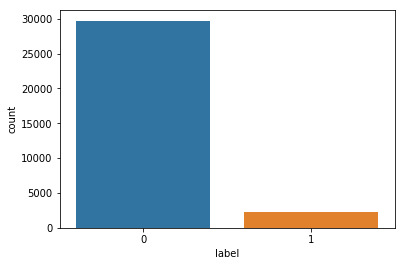

In [232]:
sns.countplot(train["label"])

In [233]:
train2 = train.drop('label', axis=1)
target = train["label"]
target.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [0]:
x_train, x_val, y_train, y_val = train_test_split(train2, target, test_size=0.3, random_state=2019)

## Vectorize

In [0]:
import string

def process_text(text):
    '''
    What will be covered:
    1. Remove punctuation
    2. Remove stopwords
    3. Return list of clean text words
    '''
    
    #1
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    #2
    clean_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    #3
    return clean_words

In [263]:
# Convert all the text into vector form

#vec = CountVectorizer(analyzer=process_text)
#vec = CountVectorizer()
#vec = CountVectorizer(stop_words='english', binary=True)
#vec = CountVectorizer(stop_words='english', ngram_range=(1,10), analyzer='char', token_pattern=r'\w{1,}', min_df=4)
#vec = CountVectorizer(stop_words='english', ngram_range=(1,4), analyzer='char', min_df=4)
#vec = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}', ngram_range=(1, 4), stop_words = 'english')

#vec = TfidfVectorizer(stop_words='english')
#vec = TfidfVectorizer(stop_words='english', sublinear_tf=True, strip_accents='unicode', analyzer='char', token_pattern=r'\w{1,}', ngram_range=(1, 3), max_features=20000)
#vec = TfidfVectorizer(ngram_range=(1,5), min_df=3, stop_words='english', max_df=0.9, strip_accents='unicode', use_idf=1, smooth_idf=1, sublinear_tf=1 )
vec = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}', ngram_range=(1, 4), use_idf=1,smooth_idf=1,sublinear_tf=1, stop_words = 'english')

#vec = HashingVectorizer()

#X_train_counts = vec.fit_transform(x_train['tweet'])
X_train_counts = vec.fit_transform(train['tweet'])

# TF-IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(31962, 23097)

In [264]:
X_val_counts = vec.transform(x_val['tweet'])
X_val_tfidf = tfidf_transformer.transform(X_val_counts)
print(X_val_tfidf.shape)

(9589, 23097)


In [265]:
X_test_counts = vec.transform(test['tweet'])
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print(X_test_tfidf.shape)

(17197, 23097)



## Different Machine Learning Models

In [0]:
#KNN
# from sklearn.neighbors import KNeighborsClassifier
# clf_knn = KNeighborsClassifier(n_neighbors=26,random_state=2019).fit(X_train_tfidf, target)
# y_pred = clf_knn.predict(X_test_tfidf)
# y_pred

In [0]:
# param_grid = dict(n_neighbors=list(range(1, 31)),weights=['uniform', 'distance'])
# print(param_grid)
# grid = GridSearchCV(clf_knn, param_grid, cv=10, scoring='accuracy')
# grid.fit(X_train_tfidf, target)
# print(grid.best_estimator_)
# print(grid.best_params_)
# print(grid.best_score_)

In [0]:
#accuracy_score(y_val, clf_knn.predict(X_val_tfidf))
# from sklearn.metrics import f1_score
# f1_score(y_true, y_pred, average='macro') 


In [0]:
#Random Forest
# from sklearn.ensemble import RandomForestClassifier
# clf_forest = RandomForestClassifier(random_state=2019,n_estimators=100).fit(X_train_tfidf, target)
# #clf_forest = RandomForestClassifier(n_estimators=200, random_state=2019, min_samples_split=2, min_samples_leaf=2, criterion="entropy", bootstrap=False).fit(X_train_tfidf, target)
# y_pred = clf_forest.predict(X_test_tfidf)
# y_pred

In [0]:
#Naive Bayes
# from sklearn.naive_bayes import MultinomialNB
# clf_nb = MultinomialNB(alpha=1,random_state=2019).fit(X_train_tfidf, target)
# y_pred = clf_nb.predict(X_test_tfidf)
# y_pred

In [0]:
#Ridge Classifier
# from sklearn.linear_model import RidgeClassifier
# clf_rdg = RidgeClassifier(alpha=1000, random_state=2019).fit(X_train_tfidf, target)
# #clf_rdg = RidgeClassifier(tol=1e+2, solver="sag").fit(X_train_tfidf, target)
# y_pred = clf_rdg.predict(X_test_tfidf)
# y_pred

In [0]:
#Gradient Boosting
# from sklearn.ensemble import GradientBoostingClassifier
# #clf_gbc = GradientBoostingClassifier(random_state=2019).fit(X_train_tfidf, target)
# clf_gbc = GradientBoostingClassifier(n_estimators=300,max_depth=5,random_state=2019).fit(X_train_tfidf, target)
# y_pred = clf_gbc.predict(X_test_tfidf)
# y_pred

In [0]:
#Ada Boost
# from sklearn.ensemble import AdaBoostClassifier
# clf_abc = AdaBoostClassifier(random_state=2019).fit(X_train_tfidf, target)
# y_pred = clf_abc.predict(X_test_tfidf)
# y_pred

In [0]:
#XG Boost Classifier
# from xgboost import XGBClassifier
# clf_xgb = XGBClassifier(random_state=2019, params = {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators':200, 'subsample':0.6, 'objective':'binary:logistic'}).fit(X_train_tfidf, target)
# y_pred = clf_xgb.predict(X_test_tfidf)
# y_pred


## Predict on test data

In [266]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
clf_log = LogisticRegression(random_state=2019, C=1000).fit(X_train_tfidf, target)
#clf_log = LogisticRegression(random_state=2019, C=100).fit(X_train_tfidf, y_train)
#clf_log = LogisticRegression(random_state=2019, solver='lbfgs',C=10).fit(X_train_tfidf, y_train)
y_pred = clf_log.predict(X_test_tfidf)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [267]:
clf_log

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=2019, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [268]:
for c in [10, 50, 100, 1000, 10000]:
    lr = LogisticRegression(C=c, random_state=2019).fit(X_train_tfidf, target)
    #lr = LogisticRegression(C=c, random_state=2019).fit(X_train_tfidf, y_train)
    print ("f1 score for C=%s: %s" % (c, f1_score(y_val, lr.predict(X_val_tfidf))))

#Accuracy for C=50: 0.9627717816361645
#f1 score for C=1000: 0.999298245614035

f1 score for C=10: 0.9291573452647277
f1 score for C=50: 0.9964862965565706
f1 score for C=100: 0.9978917779339423
f1 score for C=1000: 0.9985955056179775
f1 score for C=10000: 0.9985955056179775


In [269]:
#print(f1_score(y_val, clf_log.predict(X_val_tfidf), average='micro'))
print(f1_score(y_val, clf_log.predict(X_val_tfidf), average='macro'))
#print(f1_score(y_val, clf_log.predict(X_val_tfidf), average='weighted'))

0.999241427473853


## Submission

In [270]:
submission = {}
submission['id'] = test['id']
submission['label'] = y_pred
submission = pd.DataFrame(submission)
submission = submission[['id', 'label']]
submission.to_csv("submisision.csv", index=False)
print(submission['label'].value_counts())

0    16083
1     1114
Name: label, dtype: int64


In [271]:
!ls -ltr

total 4772
drwxr-xr-x 1 root root    4096 Aug  2 16:06 sample_data
-rw-r--r-- 1 root root 1635543 Aug 10 04:56 test.csv
-rw-r--r-- 1 root root 3103165 Aug 10 04:56 train.csv
-rw-r--r-- 1 root root  137585 Aug 10 05:52 submisision.csv


In [0]:
files.download('submisision.csv')